In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, InputLayer, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

import h5py
import json
import os
import shutil
import glob
import zipfile
import numpy as np

CLASSES = ['sandwich','sushi']
img_width, img_height = 128, 128
batch_size = 32
patience = 20 # how many epochs are we willing to wait before stopping the training early?

data_dir = "sushi_or_sandwich"
train_dir = "{}/train".format(data_dir)
test_dir = "{}/test".format(data_dir)

Using TensorFlow backend.
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Download the training photos if not already available

In [3]:
if not os.path.isfile('sushi_or_sandwich_photos.zip'):
  !wget http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip       

## Train - Test split

In [4]:
# Extract if not already extracted
if not os.path.isdir(data_dir):
    zip_ref = zipfile.ZipFile('sushi_or_sandwich_photos.zip', 'r')
    zip_ref.extractall('./')
    zip_ref.close() 

    # Delete existing folders
    for _class in CLASSES:
        for _dir in [train_dir, test_dir]:
            this = '{}/{}'.format(_dir,_class)
            print (this)
            if os.path.isdir(this):
                shutil.rmtree(this)
            os.makedirs(this)

    # Allocate images according to new train, test split and order permutation
    for _class in CLASSES:
        files = glob.glob('{}/{}/*.jpg'.format(data_dir,_class))
        indices = np.random.permutation(len(files))
        train_test_split = int(len(files)*0.8)
        for i,ix in enumerate(indices):
            src = files[ix]
            dest = '{}/{}/{}'.format(train_dir if i < train_test_split else test_dir,_class,files[ix].split('/')[-1])
            shutil.copyfile(src, dest)

## Create train and test data generators with data augmentation

In [5]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range=0.2,
    zoom_range = 0.2,
    rotation_range=30)

train_generator = datagen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "binary",
    shuffle = True,
)

test_generator = datagen.flow_from_directory(
    test_dir,
    color_mode = 'rgb',    
    target_size = (img_height, img_width),
    batch_size = batch_size,     
    class_mode = "binary",
    shuffle = True,
)

Found 642 images belonging to 2 classes.
Found 162 images belonging to 2 classes.


## Inspect a batch of training images

{'sandwich': 0, 'sushi': 1}


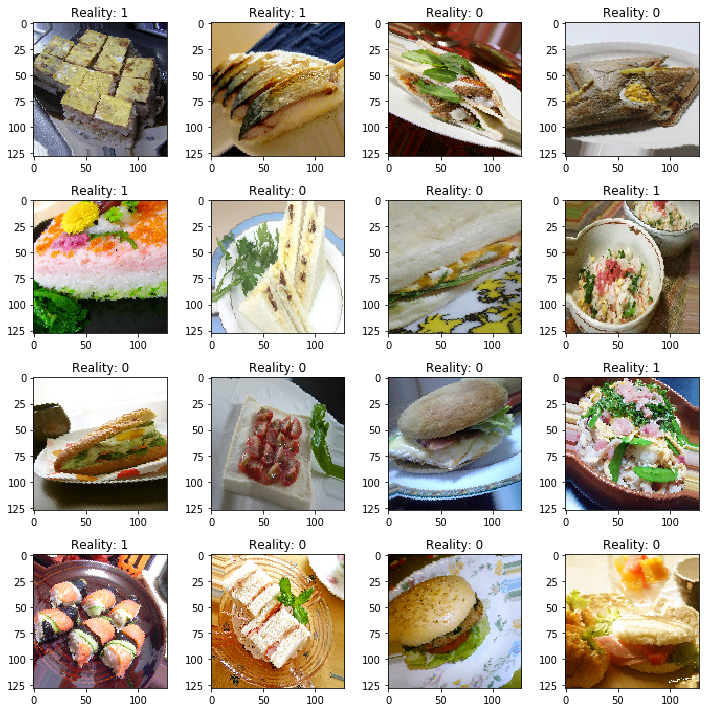

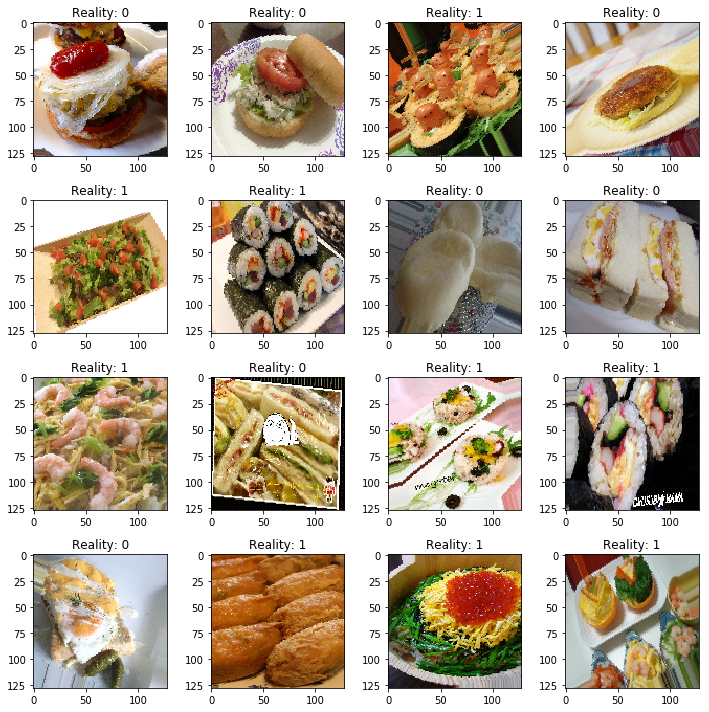

In [6]:
print(train_generator.class_indices)

images,labels=train_generator.next()

for ix,(im,l) in enumerate(zip(images,labels)):
    if ix%16 == 0:
        plt.figure(figsize=(10,10))
    plt.subplot(4,4,ix%16+1)
    plt.imshow(im)
    plt.title('Reality: {:0.0f}'.format(l))
    if (ix+1)%16 == 0:
        plt.tight_layout()

# First, let's try an ordinary CNN model

In [7]:
model = Sequential()

# inputlayer
model.add(InputLayer(input_shape=(img_width, img_height, 3)))

# conv1
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv2
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# fc1
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# fc2
model.add(Dense(1))
model.add(Activation('sigmoid'))

# output
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
__________

## Now, run the model

In [8]:
nb_epochs = 50

# train the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

if not os.path.isfile('model.h5'):

    # Save the model according to the conditions  
    checkpoint = ModelCheckpoint("checkpoint.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=patience, verbose=1, mode='auto')

    # Train the model 
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        epochs = nb_epochs,
        validation_data = test_generator,
        validation_steps = len(test_generator),
        callbacks = [checkpoint, early])

    # Dump training history to file
    with open('history.json','w') as f:
        json.dump(history.history,f,indent=True)

    # Save the model weights
    model.save_weights('model.h5')
else:
    model.load_weights('model.h5')

Epoch 1/50
21/21 [==============================] - 57s 3s/step - loss: 0.8073 - acc: 0.5422 - val_loss: 0.6923 - val_acc: 0.5000
Epoch 2/50
21/21 [==============================] - 44s 2s/step - loss: 0.6936 - acc: 0.5273 - val_loss: 0.7140 - val_acc: 0.5000
Epoch 3/50
21/21 [==============================] - 40s 2s/step - loss: 0.7034 - acc: 0.5675 - val_loss: 0.6707 - val_acc: 0.6111
Epoch 4/50
21/21 [==============================] - 37s 2s/step - loss: 0.6832 - acc: 0.5761 - val_loss: 0.6074 - val_acc: 0.7099
Epoch 5/50
21/21 [==============================] - 55s 3s/step - loss: 0.6882 - acc: 0.5865 - val_loss: 0.6485 - val_acc: 0.5123
Epoch 6/50
21/21 [==============================] - 37s 2s/step - loss: 0.6616 - acc: 0.6014 - val_loss: 0.6073 - val_acc: 0.7099
Epoch 7/50
21/21 [==============================] - 35s 2s/step - loss: 0.6668 - acc: 0.6436 - val_loss: 0.6047 - val_acc: 0.7099
Epoch 8/50
21/21 [==============================] - 40s 2s/step - loss: 0.6507 - acc: 0.62

Epoch 34/50
21/21 [==============================] - 36s 2s/step - loss: 0.5068 - acc: 0.7386 - val_loss: 0.5741 - val_acc: 0.7160
Epoch 35/50
21/21 [==============================] - 37s 2s/step - loss: 0.5490 - acc: 0.7088 - val_loss: 0.6437 - val_acc: 0.6358
Epoch 36/50
21/21 [==============================] - 35s 2s/step - loss: 0.5063 - acc: 0.7550 - val_loss: 0.5907 - val_acc: 0.7407
Epoch 37/50
21/21 [==============================] - 40s 2s/step - loss: 0.5044 - acc: 0.7550 - val_loss: 0.6814 - val_acc: 0.6173
Epoch 38/50
21/21 [==============================] - 34s 2s/step - loss: 0.4975 - acc: 0.7674 - val_loss: 0.5934 - val_acc: 0.7346
Epoch 39/50
21/21 [==============================] - 39s 2s/step - loss: 0.5059 - acc: 0.7595 - val_loss: 0.7615 - val_acc: 0.7222
Epoch 00039: early stopping


## How did the model perform?

70.28% mean accuracy in the final 20 epochs.


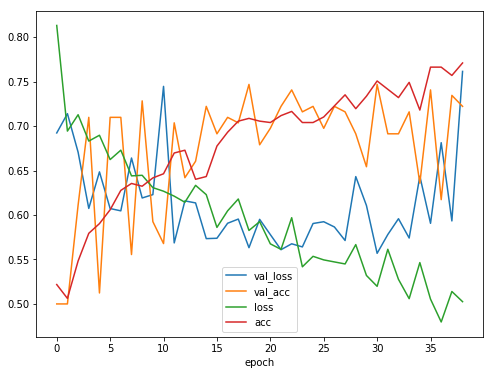

In [ ]:
with open('history.json','r') as f:
    h = json.load(f)

plt.figure(figsize=(8,6))
for k,v in h.items():
    plt.plot(v,label=k)
plt.legend()
plt.xlabel('epoch')

print('{:0.2f}% mean accuracy in the final {} epochs.'.format(np.mean(h['val_acc'][-patience:])*100, patience))

# Can we do better using [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) weights trained on Imagenet dataset?

In [6]:
# Get the weights of all except the final layer
if not os.path.isfile('mobilenet_1_0_128_tf_no_top.h5'):
    !wget https://github.com/fchollet/deep-learning-models/releases/download/v0.6/mobilenet_1_0_128_tf_no_top.h5
model_bottleneck = applications.MobileNet(weights='mobilenet_1_0_128_tf_no_top.h5',include_top=False,input_shape=(img_height,img_width,3))

# Disable training in all layers as we do not want to touch the weights
for layer in model_bottleneck.layers:
    layer.trainable = False

In [7]:
model_bottleneck.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

In [8]:
if not os.path.isfile('features-bottleneck.h5'):
    train_bottleneck_generator = datagen.flow_from_directory(
        train_dir,
        color_mode = 'rgb',
        target_size = (img_height, img_width),
        batch_size = batch_size, 
        class_mode = None,
        shuffle = False,
    )
    test_bottleneck_generator = datagen.flow_from_directory(
        test_dir,
        color_mode = 'rgb',    
        target_size = (img_height, img_width),
        batch_size = batch_size,     
        class_mode = None,
        shuffle = False,
    )    
    train_bottleneck = model_bottleneck.predict_generator(train_bottleneck_generator,verbose=1)
    test_bottleneck = model_bottleneck.predict_generator(test_bottleneck_generator,verbose=1) 
    train_labels = train_generator.classes
    test_labels = test_generator.classes
    with h5py.File('features-bottleneck.h5','w') as f:
        f['train/bottleneck'] = train_bottleneck
        f['test/bottleneck'] = test_bottleneck
        f['train/labels'] = train_labels
        f['test/labels'] = test_labels
        
with h5py.File('features-bottleneck.h5','r') as f:
    train_bottleneck = np.array(f['train/bottleneck'])
    test_bottleneck = np.array(f['test/bottleneck'])
    train_labels = np.array(f['train/labels'])
    test_labels = np.array(f['test/labels'])    

Found 642 images belonging to 2 classes.
Found 162 images belonging to 2 classes.
6/6 [==============================] - 18s 3s/step


## Train the second-to-last layer weights against the binary categories

In [9]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_bottleneck.shape[1:]))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

model_top.summary()

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 4,194,817
Trainable params: 4,194,817
Non-trainable params: 0
_________________________________________________________________


In [10]:
nb_epoch=50

if not os.path.isfile('model-top.h5'):
    checkpoint = ModelCheckpoint("checkpoint-top.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=patience, verbose=1, mode='auto')

    history_top = model_top.fit(
        train_bottleneck,
        train_labels,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(test_bottleneck, test_labels),
        callbacks=[checkpoint,early])
    
    # Dump training history to file
    with open('history-top.json','w') as f:
        json.dump(history_top.history,f,indent=True)

    # Save the model weights
    model_top.save_weights('model-top.h5')
else:
    model_top.load_weights('model-top.h5')    

Train on 642 samples, validate on 162 samples
Epoch 1/50
642/642 [==============================] - 4s 5ms/step - loss: 5.2621 - acc: 0.6028 - val_loss: 2.8287 - val_acc: 0.7778
Epoch 2/50
642/642 [==============================] - 3s 5ms/step - loss: 2.8205 - acc: 0.7788 - val_loss: 2.2958 - val_acc: 0.8086
Epoch 3/50
642/642 [==============================] - 2s 3ms/step - loss: 1.9747 - acc: 0.8302 - val_loss: 2.1748 - val_acc: 0.8025
Epoch 4/50
642/642 [==============================] - 2s 3ms/step - loss: 1.6112 - acc: 0.8676 - val_loss: 2.4230 - val_acc: 0.8086
Epoch 5/50
642/642 [==============================] - 3s 4ms/step - loss: 1.8445 - acc: 0.8614 - val_loss: 2.4371 - val_acc: 0.8148
Epoch 6/50
642/642 [==============================] - 2s 4ms/step - loss: 1.3932 - acc: 0.8707 - val_loss: 1.8935 - val_acc: 0.8457
Epoch 7/50
642/642 [==============================] - 2s 4ms/step - loss: 1.0188 - acc: 0.9081 - val_loss: 2.5092 - val_acc: 0.8086
Epoch 8/50
642/642 [==========

642/642 [==============================] - 3s 5ms/step - loss: 0.1529 - acc: 0.9891 - val_loss: 1.8527 - val_acc: 0.8457
Epoch 33/50
642/642 [==============================] - 2s 3ms/step - loss: 0.1308 - acc: 0.9907 - val_loss: 1.9125 - val_acc: 0.8580
Epoch 34/50
642/642 [==============================] - 2s 3ms/step - loss: 0.1248 - acc: 0.9922 - val_loss: 2.0649 - val_acc: 0.8457
Epoch 35/50
642/642 [==============================] - 2s 3ms/step - loss: 0.1247 - acc: 0.9922 - val_loss: 2.1298 - val_acc: 0.8272
Epoch 36/50
642/642 [==============================] - 2s 3ms/step - loss: 0.1656 - acc: 0.9875 - val_loss: 1.8022 - val_acc: 0.8642
Epoch 37/50
642/642 [==============================] - 3s 4ms/step - loss: 0.1247 - acc: 0.9922 - val_loss: 1.8899 - val_acc: 0.8457
Epoch 38/50
642/642 [==============================] - 2s 4ms/step - loss: 0.1293 - acc: 0.9907 - val_loss: 2.1551 - val_acc: 0.8395
Epoch 39/50
642/642 [==============================] - 3s 4ms/step - loss: 0.1247

NameError: name 'model' is not defined

85.03% mean accuracy in the final 20 epochs.


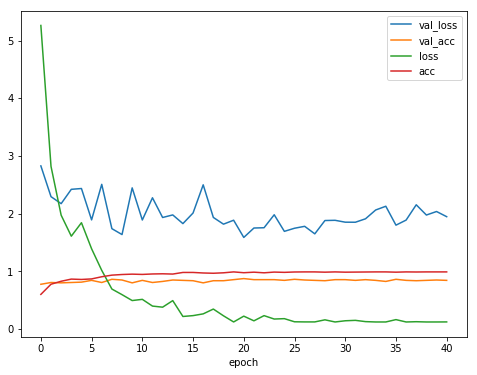

In [12]:
# Load training history to file
with open('history-top.json','r') as f:
    h = json.load(f)

plt.figure(figsize=(8,6))
for k,v in h.items():
    plt.plot(v,label=k)
plt.legend()
plt.xlabel('epoch')

print('{:0.2f}% mean accuracy in the final {} epochs.'.format(np.mean(h['val_acc'][-patience:])*100,patience))

## Let's stack the top layer on top of MobileNet to make a real-time predictor

In [13]:
model_stacked = Model(inputs=model_bottleneck.input, outputs=model_top(model_bottleneck.output))
model_stacked.summary()
model_stacked.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

{'sandwich': 0, 'sushi': 1}


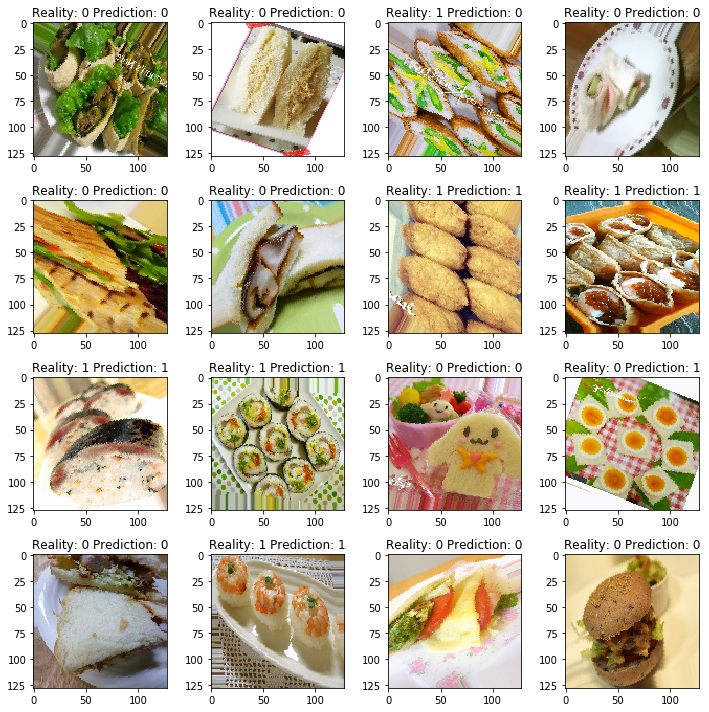

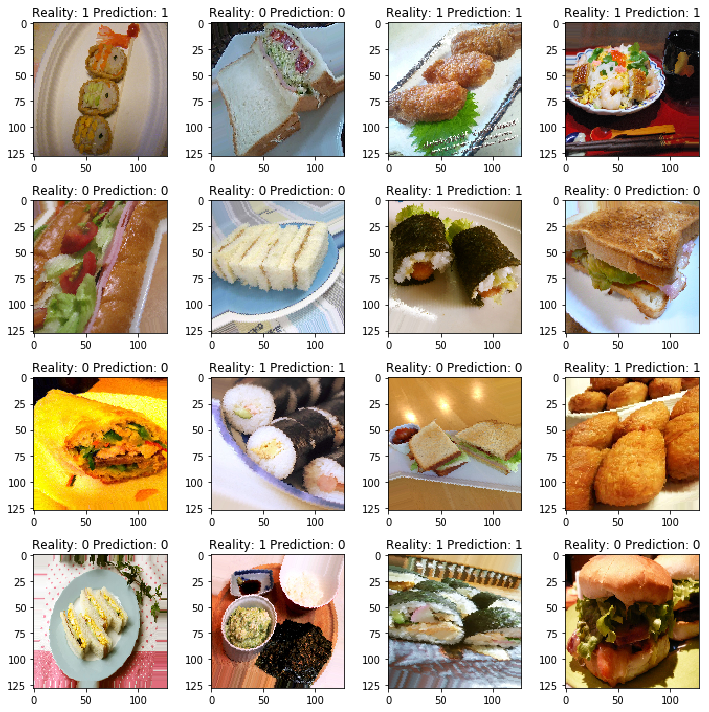

In [14]:
print(test_generator.class_indices)

images,labels = test_generator.next()
predictions = model_stacked.predict(images)

for ix,(im,l,p) in enumerate(zip(images,labels,predictions.flatten())):
    if ix%16 == 0:
        plt.figure(figsize=(10,10))
    plt.subplot(4,4,ix%16+1)
    plt.imshow(im)
    plt.title('Reality: {:0.0f} Prediction: {:0.0f}'.format(l,p))
    if (ix+1)%16 == 0:
        plt.tight_layout()